## From utils:

In [1]:
import numpy as np
import os
from pathlib import Path
from skimage.io import imread
from skimage import measure
from shapely.geometry import Polygon
from shapely.validation import make_valid
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional

In [2]:
def get_polygon_from_instance_segmentation(single_plane: np.ndarray, label_id: int) -> Polygon:
    x_dim, y_dim = single_plane.shape
    tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
    tmp_array[np.where(single_plane == label_id)] = 1
    tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
    roi = Polygon(tmp_contours)
    if roi.is_valid == False:
        roi = make_valid(roi)
    return roi


def listdir_nohidden(path: Path) -> List:
    return [f for f in os.listdir(path) if f.startswith('.') == False]


def load_zstack_as_array_from_single_planes(path: Path, file_id: str, 
                                            minx: Optional[int]=None, maxx: Optional[int]=None, 
                                            miny: Optional[int]=None, maxy: Optional[int]=None) -> np.ndarray:
    types = list(set([type(minx), type(maxx), type(miny), type(maxy)]))    
    if any([minx, maxx, miny, maxy]):
        if (len(types) == 1) & (types[0] == int):
            cropping = True
        else:
            raise TypeError("'minx', 'maxx', 'miny', and 'maxy' all have to be integers - or None if no cropping has to be done")
    else:
        cropping = False
    filenames = [filename for filename in listdir_nohidden(path) if filename.startswith(file_id)]
    cropped_zstack = list()
    for single_plane_filename in filenames:
        tmp_image = imread(path.joinpath(single_plane_filename))
        if cropping:
            tmp_image = tmp_image[minx:maxx, miny:maxy]
        cropped_zstack.append(tmp_image.copy())
        del tmp_image
    return np.asarray(cropped_zstack)


def unpad_x_y_dims_in_3d_array(padded_3d_array: np.ndarray, pad_width: int) -> np.ndarray:
    return padded_3d_array[:, pad_width:padded_3d_array.shape[1]-pad_width, pad_width:padded_3d_array.shape[2]-pad_width]

## From postprocessing

In [3]:
# additional imports:

from PIL import Image
from skimage import measure
from skimage.io import imsave, imread
import cc3d

In [4]:
def run_3d_instance_reconstruction(zstack: np.ndarray) -> Tuple[np.ndarray, Dict]:
    pad_width, lowest_final_label_id = 1, 2000
    zstack = np.pad(zstack, pad_width = pad_width, mode = 'constant', constant_values = 0)
    zstack = zstack[pad_width : zstack.shape[0] - pad_width]
    roi_matching_results = get_plane_to_plane_roi_matching_results(zstack = zstack)
    for plane_id in range(zstack.shape[0]):
        for label_id in roi_matching_results[plane_id].keys():
            roi_matching_results[plane_id][label_id] = find_best_matches(all_results = roi_matching_results, 
                                                                         original_plane_id = plane_id,
                                                                         original_label_id = label_id)
    final_ids, roi_matching_results = get_final_id_assignments(results = roi_matching_results, lowest_final_label_id = lowest_final_label_id)
    zstack = unpad_x_y_dims_in_3d_array(padded_3d_array = zstack, pad_width = pad_width)
    postprocessed_zstack = set_new_label_ids(zstack_with_old_label_ids = zstack, new_ids_assignment = final_ids)
    return postprocessed_zstack, roi_matching_results, final_ids # return of final_ids was added

In [5]:
def get_plane_to_plane_roi_matching_results(zstack: np.ndarray, verbose: Optional[bool]=True) -> Dict:
    z_dim, x_dim, y_dim = zstack.shape
    results = dict()        
    for plane_idx in range(z_dim):
        if verbose:
            print(f'--matching ROIs across planes ({plane_idx + 1}/{z_dim})')
        results[plane_idx] = dict()
        if plane_idx == 0:
            previous_plane_info = (None, 'previous')
            next_plane_info = (plane_idx + 1, 'next')
        elif plane_idx == z_dim - 1:
            previous_plane_info = (plane_idx - 1, 'previous')
            next_plane_info = (None, 'next')
        else:
            previous_plane_info = (plane_idx - 1, 'previous')
            next_plane_info = (plane_idx + 1, 'next')
        plane = zstack[plane_idx]
        unique_label_ids = list(np.unique(plane))
        if 0 in unique_label_ids:
            unique_label_ids.remove(0)
        elif 0.0 in unique_label_ids:
            unique_label_ids.remove(0.0)
        for label_id in unique_label_ids:
            roi = get_polygon_from_instance_segmentation(single_plane = zstack[plane_idx], label_id = label_id)
            roi_area = roi.area
            results[plane_idx][label_id] = {'final_label_id_assigned': False,
                                            'final_label_id': None,
                                            'area': roi_area,
                                            'matching_ids_previous_plane': list(),
                                            'full_overlap_previous_plane': list(),
                                            'overlapping_area_previous_plane': list(),
                                            'IoUs_previous_plane': list(),
                                            'matching_ids_next_plane': list(),
                                            'full_overlap_next_plane': list(),
                                            'overlapping_area_next_plane': list(),
                                            'IoUs_next_plane': list(),
                                            'best_match_previous_plane': None,
                                            'overlapping_area_best_match_previous_plane': None,
                                            'IoU_best_match_previous_plane': None,
                                            'best_match_next_plane': None,
                                            'overlapping_area_best_match_next_plane': None,
                                            'IoU_best_match_next_plane': None}
            for plane_to_compare_info in [previous_plane_info, next_plane_info]:
                if plane_to_compare_info[0] != None:
                    plane_to_compare_idx, plane_indicator = plane_to_compare_info[0], plane_to_compare_info[1]
                    labels_of_pixels_in_plane_to_compare = zstack[plane_to_compare_idx][np.where(plane == label_id)]
                    labels_of_pixels_in_plane_to_compare = list(np.unique(labels_of_pixels_in_plane_to_compare))
                    if 0 in labels_of_pixels_in_plane_to_compare:
                        labels_of_pixels_in_plane_to_compare.remove(0)
                    elif 0.0 in labels_of_pixels_in_plane_to_compare:
                        labels_of_pixels_in_plane_to_compare.remove(0.0)
                    for label_id_in_plane_to_compare in labels_of_pixels_in_plane_to_compare:
                        roi_to_compare = get_polygon_from_instance_segmentation(single_plane = zstack[plane_to_compare_idx], 
                                                                                label_id = label_id_in_plane_to_compare)
                        results[plane_idx][label_id] = roi_matching(original_roi = roi, 
                                                                    roi_to_compare = roi_to_compare, 
                                                                    label_id_roi_to_compare =  label_id_in_plane_to_compare, 
                                                                    results = results[plane_idx][label_id], 
                                                                    plane_indicator = plane_indicator)
    return results

In [6]:
def roi_matching(original_roi: Polygon, roi_to_compare: Polygon, label_id_roi_to_compare: int, results: Dict, plane_indicator: str) -> Dict:
    iou = original_roi.intersection(roi_to_compare).area / original_roi.union(roi_to_compare).area
    proportion = original_roi.intersection(roi_to_compare).area / original_roi.area
    if original_roi.within(roi_to_compare): 
        within = True
    else: 
        within = False
    results[f'matching_ids_{plane_indicator}_plane'].append(label_id_roi_to_compare)
    results[f'full_overlap_{plane_indicator}_plane'].append(within)
    results[f'overlapping_area_{plane_indicator}_plane'].append(proportion)
    results[f'IoUs_{plane_indicator}_plane'].append(iou)
    return results

In [7]:
def find_best_matches(all_results: Dict, original_plane_id: int, original_label_id: int) -> Dict:
    results = all_results[original_plane_id][original_label_id].copy()
    for plane_indicator in ['previous', 'next']:
        if len(results[f'matching_ids_{plane_indicator}_plane']) > 0:
            if plane_indicator == 'previous':
                reciprocal_plane_indicator = 'next'
                reciprocal_plane_id = original_plane_id - 1
            else:
                reciprocal_plane_indicator = 'previous'
                reciprocal_plane_id = original_plane_id + 1
            within = any(results[f'full_overlap_{plane_indicator}_plane'])
            # First exit: our ROI is fully within another ROI, obviously making it our best match:
            if within:
                index_of_reciprocal_label_id = results[f'full_overlap_{plane_indicator}_plane'].index(True)
                reciprocal_label_id = results[f'matching_ids_{plane_indicator}_plane'][index_of_reciprocal_label_id]
                reciprocal_results = all_results[reciprocal_plane_id][reciprocal_label_id].copy()
                other_label_ids_within_reciprocal_label_id = list()
                for label_id_matching_with_reciprocal_label_id in reciprocal_results[f'matching_ids_{reciprocal_plane_indicator}_plane']:
                    tmp_results = all_results[original_plane_id][label_id_matching_with_reciprocal_label_id].copy()
                    index_reciprocal_label_id = tmp_results[f'matching_ids_{plane_indicator}_plane'].index(reciprocal_label_id)
                    if tmp_results[f'full_overlap_{plane_indicator}_plane'][index_reciprocal_label_id]:
                        iou_other_label_id_to_reciprocal_label_id = tmp_results[f'IoUs_{plane_indicator}_plane'][index_reciprocal_label_id]
                        other_label_ids_within_reciprocal_label_id.append((label_id_matching_with_reciprocal_label_id, iou_other_label_id_to_reciprocal_label_id))
                index_reciprocal_label_id = results[f'matching_ids_{plane_indicator}_plane'].index(reciprocal_label_id)
                max_iou = results[f'IoUs_{plane_indicator}_plane'][index_reciprocal_label_id]
                best_matching_label_id = original_label_id
                if len(other_label_ids_within_reciprocal_label_id) > 0:
                    for other_label_id, iou_other_label_id in other_label_ids_within_reciprocal_label_id:
                        if iou_other_label_id > max_iou:
                            best_matching_label_id = other_label_id
                        elif iou_other_label_id == max_iou:
                            best_matching_label_id = min([best_matching_label_id, other_label_id])
                if best_matching_label_id == original_label_id:
                    best_match_index = results[f'full_overlap_{plane_indicator}_plane'].index(True)
                else:
                    best_match_index = None
            else:
                reciprocal_within_label_ids = list()
                reciprocal_label_ids_to_be_excluded = list()
                for reciprocal_label_id in results[f'matching_ids_{plane_indicator}_plane']:
                    reciprocal_results = all_results[reciprocal_plane_id][reciprocal_label_id].copy()
                    index_original_label_id = reciprocal_results[f'matching_ids_{reciprocal_plane_indicator}_plane'].index(original_label_id)
                    # Is the reciprocal roi within our original roi?
                    if reciprocal_results[f'full_overlap_{reciprocal_plane_indicator}_plane'][index_original_label_id]:
                        reciprocal_within_label_ids.append(reciprocal_label_id)
                    # Is the reciprocal roi within another roi [not our original roi]?
                    elif any(reciprocal_results[f'full_overlap_{reciprocal_plane_indicator}_plane']):
                        reciprocal_label_ids_to_be_excluded.append(reciprocal_label_id)
                    # Is there a third roi (a roi that overlaps with the reciprocal roi) - that is fully within the reciprocal roi?
                    else:
                        other_label_ids_within_reciprocal_label_id = list()
                        for label_id_matching_with_reciprocal_label_id in reciprocal_results[f'matching_ids_{reciprocal_plane_indicator}_plane']:
                            tmp_results = all_results[original_plane_id][label_id_matching_with_reciprocal_label_id].copy()
                            index_reciprocal_label_id = tmp_results[f'matching_ids_{plane_indicator}_plane'].index(reciprocal_label_id)
                            # right now within´s are always prioritized over overlapping potential best matches. 
                            # So if there is any ROI that has a full overlapt (=within) our potential best matching reciprocal ROI - this reciprocal ROI will be excluded
                            if tmp_results[f'full_overlap_{plane_indicator}_plane'][index_reciprocal_label_id]:
                                reciprocal_label_ids_to_be_excluded.append(reciprocal_label_id)
                # Second exit: (at least) one matching ROI is fully within our original ROI and, therefore, has to be considered as best match:
                if len(reciprocal_within_label_ids) > 0:
                    max_iou = -1
                    best_reciprocal_within_label_id = None
                    for reciprocal_label_id in reciprocal_within_label_ids:
                        index_reciprocal_label_id = results[f'matching_ids_{plane_indicator}_plane'].index(reciprocal_label_id)
                        tmp_matching_iou = results[f'IoUs_{plane_indicator}_plane'][index_reciprocal_label_id]
                        if tmp_matching_iou > max_iou:
                            best_reciprocal_within_label_id = reciprocal_label_id
                            max_iou = tmp_matching_iou
                        elif tmp_matching_iou == max_iou:
                            best_reciprocal_within_label_id = min([best_reciprocal_within_label_id, reciprocal_label_id])
                    best_match_index = results[f'matching_ids_{plane_indicator}_plane'].index(best_reciprocal_within_label_id) 
                else: # neither an original within, nor a reciprocal within - time to look for the highest IOU then:
                    max_iou = max(results[f'IoUs_{plane_indicator}_plane'])
                    max_iou_index = results[f'IoUs_{plane_indicator}_plane'].index(max_iou)
                    reciprocal_label_id = results[f'matching_ids_{plane_indicator}_plane'][max_iou_index]
                    # Third exit: The best matching ROI of our original ROI is fully within another ROI within the same plane as our original ROI --> no match!
                    if reciprocal_label_id in reciprocal_label_ids_to_be_excluded:
                        best_match_index = None
                    else:
                        reciprocal_results = all_results[reciprocal_plane_id][reciprocal_label_id].copy()
                        reciprocal_max_iou = max(reciprocal_results[f'IoUs_{reciprocal_plane_indicator}_plane'])
                        reciprocal_max_iou_index = reciprocal_results[f'IoUs_{reciprocal_plane_indicator}_plane'].index(reciprocal_max_iou)
                        # Fourth exit: Our original ROI is also the best matching ROI for its´ own best matching ROI: 
                        if original_label_id == reciprocal_results[f'matching_ids_{reciprocal_plane_indicator}_plane'][reciprocal_max_iou_index]:
                            best_match_index = max_iou_index
                        # Fifth and final exit: Our original ROI is not the best matching ROI of its´ own best match --> no match!
                        else:
                            best_match_index = None                    
            if type(best_match_index) == int:
                best_match_label_id = results[f'matching_ids_{plane_indicator}_plane'][best_match_index]
                best_match_iou = results[f'IoUs_{plane_indicator}_plane'][best_match_index]
                best_match_overlap = results[f'overlapping_area_{plane_indicator}_plane'][best_match_index]
            else: 
                best_match_label_id, best_match_iou, best_match_overlap = None, None, None
            results[f'best_match_{plane_indicator}_plane'] = best_match_label_id
            results[f'overlapping_area_best_match_{plane_indicator}_plane'] = best_match_overlap
            results[f'IoU_best_match_{plane_indicator}_plane'] = best_match_iou
    return results

In [8]:
def get_final_id_assignments(results: Dict, lowest_final_label_id: int=2000) -> Tuple[Dict, Dict]:
    final_ids = dict()
    keep_going = True
    final_label_id = lowest_final_label_id
    for plane_idx in results.keys():
        for label_id in results[plane_idx].keys():
            if results[plane_idx][label_id]['final_label_id_assigned']:
                continue
            else:
                final_ids[final_label_id] = {'plane_index': list(),
                                             'original_label_id': list()}
                results[plane_idx][label_id]['final_label_id_assigned'] = True
                results[plane_idx][label_id]['final_label_id'] = final_label_id
                final_ids[final_label_id]['plane_index'].append(plane_idx)
                final_ids[final_label_id]['original_label_id'].append(label_id)
                # Now start tracing:
                if results[plane_idx][label_id]['best_match_next_plane'] != None:
                    keep_tracing = True
                    while keep_tracing:
                        results, final_ids, keep_tracing = trace_matches(matching_results = results, 
                                                                         final_ids_assignment = final_ids, 
                                                                         current_final_id = final_label_id)
                final_label_id += 1
    return final_ids, results

In [9]:
def trace_matches(matching_results: Dict, final_ids_assignment: Dict, current_final_id: int) -> Tuple[Dict, Dict, bool]:
    current_plane_idx = final_ids_assignment[current_final_id]['plane_index'][-1]
    current_plane_label_id = final_ids_assignment[current_final_id]['original_label_id'][-1]
    best_match_next_plane = matching_results[current_plane_idx][current_plane_label_id]['best_match_next_plane']
    next_plane_idx = current_plane_idx + 1
    if matching_results[next_plane_idx][best_match_next_plane]['final_label_id_assigned']:
        print(f'Was trying to trace down the matches of original_label_id: {current_plane_label_id} in plane {current_plane_idx}')
        raise ValueError(f'ROI with ID {best_match_next_plane} in plane {next_plane_idx} was already assigned! :o')
    else:
        if matching_results[next_plane_idx][best_match_next_plane]['best_match_previous_plane'] != current_plane_label_id:
            raise ValueError(f'ROI with ID {best_match_next_plane} in plane {next_plane_idx} does not share best matching with previous plane!')
        else:
            matching_results[next_plane_idx][best_match_next_plane]['final_label_id_assigned'] = True
            matching_results[next_plane_idx][best_match_next_plane]['final_label_id'] = current_final_id
            final_ids_assignment[current_final_id]['plane_index'].append(next_plane_idx)
            final_ids_assignment[current_final_id]['original_label_id'].append(best_match_next_plane)
            if matching_results[next_plane_idx][best_match_next_plane]['best_match_next_plane'] != None:
                keep_tracing = True
            else:
                keep_tracing = False
    return matching_results, final_ids_assignment, keep_tracing

# Line 3 in the following cell needs to be added to convert from dtype uint8 to 16!

In [10]:
def set_new_label_ids(zstack_with_old_label_ids: np.ndarray, new_ids_assignment: Dict) -> np.ndarray:
    zstack_with_new_label_ids = zstack_with_old_label_ids.copy()
    zstack_with_new_label_ids = zstack_with_new_label_ids.astype('uint16')
    for new_label_id in new_ids_assignment.keys():
        for idx in range(len(new_ids_assignment[new_label_id]['plane_index'])):
            plane_index = new_ids_assignment[new_label_id]['plane_index'][idx]
            old_label_id = new_ids_assignment[new_label_id]['original_label_id'][idx]
            zstack_with_new_label_ids[plane_index][np.where(zstack_with_new_label_ids[plane_index] == old_label_id)] = new_label_id
    return zstack_with_new_label_ids 

### Continue with ApplyExclusionCriteria

In [35]:
# This is the code we want to be able to run in the debugging section below

def for_debugging(zstack: np.ndarray, rois_dict: Dict) -> Dict:
    instance_label_info = get_instance_label_info(zstack = zstack, rois_dict = rois_dict)
    exclusion_criteria = get_exclusion_criteria(zstack = zstack)
    all_area_roi_ids = get_all_unique_area_roi_ids(rois_dict = rois_dict)
    segmentations_per_area_roi_id = dict()
    for area_roi_id in all_area_roi_ids:
        segmentations_per_area_roi_id[area_roi_id] = apply_exclusion_criteria(zstack_prior_to_exclusion = zstack,
                                                                               area_roi_id = area_roi_id,
                                                                               info = instance_label_info,
                                                                               exclusion_criteria = exclusion_criteria)
    return segmentations_per_area_roi_id

In [36]:
# this had to be adapted for debugging: we had to get rid of the PostprocessingObject
def get_instance_label_info(zstack: np.ndarray, rois_dict: Dict) -> Dict:
    instance_label_ids = list(np.unique(zstack))
    for background_label in [0, 0.0]:
        if background_label in instance_label_ids:
            instance_label_ids.remove(background_label)
    instance_label_info = dict()
    for label_id in instance_label_ids:
        instance_label_info[label_id] = dict()
        plane_indices_with_label_id = list(set(np.where(zstack == label_id)[0]))
        instance_label_info[label_id]['plane_indices_with_label_id'] = plane_indices_with_label_id
    instance_label_info = extend_info_with_relative_positions(info = instance_label_info, 
                                                               rois_dict = rois_dict,
                                                               zstack = zstack)
    return instance_label_info

In [37]:
def extend_info_with_relative_positions(info: Dict, rois_dict: Dict, zstack: np.ndarray) -> Dict:
    for label_id in info.keys():
        info[label_id]['area_roi_ids_with_matching_plane_index_and_id'] = list()
        info[label_id]['relative_positions_per_area_roi_id'] = dict()
        for plane_index in info[label_id]['plane_indices_with_label_id']:
            if plane_index in rois_dict.keys():
                for area_roi_id in rois_dict[plane_index]:
                    if (area_roi_id, plane_index, plane_index) not in info[label_id]['area_roi_ids_with_matching_plane_index_and_id']:
                        info[label_id]['area_roi_ids_with_matching_plane_index_and_id'].append((area_roi_id, plane_index, plane_index))
            if 'all_planes' in rois_dict.keys(): # no elif, since there might be some ROIs assigned to single planes and others for the entire stack
                for area_roi_id in rois_dict['all_planes']:
                    if (area_roi_id, plane_index, 'all_planes') not in info[label_id]['area_roi_ids_with_matching_plane_index_and_id']:
                        info[label_id]['area_roi_ids_with_matching_plane_index_and_id'].append((area_roi_id, plane_index, 'all_planes'))
        for area_roi_id, plane_index, plane_id in info[label_id]['area_roi_ids_with_matching_plane_index_and_id']:
            roi = get_polygon_from_instance_segmentation(single_plane = zstack[plane_index], label_id = label_id)
            area_roi = rois_dict[plane_id][area_roi_id]
            relative_position = get_relative_position(roi_to_check = roi, reference = area_roi)
            if area_roi_id not in info[label_id]['relative_positions_per_area_roi_id'].keys():
                info[label_id]['relative_positions_per_area_roi_id'][area_roi_id] = {'relative_positions': list(),
                                                                                     'plane_indices': list()}
            info[label_id]['relative_positions_per_area_roi_id'][area_roi_id]['relative_positions'].append(relative_position)
            info[label_id]['relative_positions_per_area_roi_id'][area_roi_id]['plane_indices'].append(plane_index)
        for area_roi_id in info[label_id]['relative_positions_per_area_roi_id'].keys():
            relative_positions = list(set(info[label_id]['relative_positions_per_area_roi_id'][area_roi_id]['relative_positions']))
            if 'within' in relative_positions:
                final_relative_position_for_quantifications = 'within'
            elif 'intersects' in relative_positions:
                final_relative_position_for_quantifications = 'intersects'
            elif 'touches' in relative_positions:
                final_relative_position_for_quantifications = 'touches'
            else:
                final_relative_position_for_quantifications = 'no_overlap'
            info[label_id]['relative_positions_per_area_roi_id'][area_roi_id]['final_relative_position_for_quantifications'] = final_relative_position_for_quantifications
    return info

In [38]:
def get_relative_position(roi_to_check: Polygon, reference: Polygon) -> str:
    if roi_to_check.within(reference):
        rel_position = 'within'
    elif roi_to_check.intersects(reference):
        rel_position = 'intersects'
    elif roi_to_check.touches(reference):
        rel_position = 'touches'
    else:
        rel_position = 'no_overlap'
    return rel_position

In [39]:
def get_exclusion_criteria(zstack: np.ndarray) -> Dict:
    #database = postprocessing_object.database
    total_planes = zstack.shape[0]
    exclusion_criteria = dict()
    """
    if hasattr(database, 'quantification_configs') == False:
        database.quantification_configs = dict()
    if 'exclusion_criteria' in database.quantification_configs.keys():
        if 'allowed_relative_positions' in database.quantification_configs['exclusion_criteria'].keys():
            exclusion_criteria['allowed_relative_positions'] = database.quantification_configs['exclusion_criteria']['allowed_relative_positions']
        if 'minimum_planes_covered' in database.quantification_configs['exclusion_criteria'].keys():
            exclusion_criteria['minimum_planes_covered'] = database.quantification_configs['exclusion_criteria']['minimum_planes_covered']
        if len(list(exclusion_criteria.keys())) < 1:
            warning_line0 = "Warning: You added 'exclusion_criteria' as attribute to the database, but it does not contain valid entries.\n"
            warning_line1 = "         The correct keys are: 'allowed_relative_positions' and 'minimum_planes_covered'."
            warning = warning_line0 + warning_line1
            print(warning)
    """
    if 'allowed_relative_positions' not in exclusion_criteria.keys():
        exclusion_criteria['allowed_relative_positions'] = ['within', 'intersects']
    if 'minimum_planes_covered' not in exclusion_criteria.keys():
        if total_planes > 1:
            minimum_planes_covered = 2
        else:
            minimum_planes_covered = 1
        exclusion_criteria['minimum_planes_covered'] = minimum_planes_covered
    return exclusion_criteria

In [40]:
def get_all_unique_area_roi_ids(rois_dict: Dict) -> List:
    unique_area_roi_ids = list()
    for plane_id in rois_dict.keys():
        for area_roi_id in rois_dict[plane_id]:
            if area_roi_id not in unique_area_roi_ids:
                unique_area_roi_ids.append(area_roi_id)
    return unique_area_roi_ids

In [41]:
def apply_exclusion_criteria(zstack_prior_to_exclusion: np.ndarray, area_roi_id: str, info: Dict, exclusion_criteria: Dict) -> np.ndarray:
    zstack = zstack_prior_to_exclusion.copy()
    for label_id in info.keys():
        relative_position = info[label_id]['relative_positions_per_area_roi_id'][area_roi_id]['final_relative_position_for_quantifications']
        max_z_expansion = get_max_z_expansion(planes = info[label_id]['plane_indices_with_label_id'])
        if relative_position not in exclusion_criteria['allowed_relative_positions']:
            zstack[np.where(zstack == label_id)] = 0
        if max_z_expansion < exclusion_criteria['minimum_planes_covered']:
            zstack[np.where(zstack == label_id)] = 0
    return zstack

In [42]:
def get_max_z_expansion(planes: List) -> int:
    z_dim_expansions = list()
    for index in range(len(planes)):
        z_dim_expansions.append(count_continous_plane_ids(start_index = index, plane_indices = planes))
    return max(z_dim_expansions)

In [43]:
def count_continous_plane_ids(start_index: int, plane_indices: List) -> int:
    index = start_index
    keep_going = True
    while keep_going:
        if index < len(plane_indices) - 1:
            if plane_indices[index + 1] == plane_indices[index] + 1:
                if index < len(plane_indices) - 1:
                    index += 1
                else:
                    keep_going = False
            else:
                keep_going = False
        else:
            keep_going = False
    return index - start_index + 1

## Run the code for debugging:

Import area ROI for buggy file and extract boundary coordinates:

In [11]:
import pickle

with open('my_polygon', "rb") as poly_file:
    loaded_polygon = pickle.load(poly_file)
    
y, x = loaded_polygon.boundary.xy

Load the corresponding instance segmentations and verify with a quick plot that the area ROI file is indeed matching:

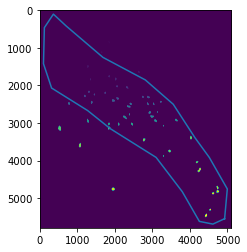

In [12]:
path = Path('/mnt/c/Users/dsege/TEMP/findmycells_projects/debugging_2/TH_in_SN_new_scanner/03c_instance_segmentations/')
zstack = load_zstack_as_array_from_single_planes(path, '0004')

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.imshow(zstack[8])

Alright - so now let´s execute the code to see the results to get an idea where the bug might occur:

In [15]:
reconstructed_zstack, roi_matching_results, final_ids = run_3d_instance_reconstruction(zstack = zstack)

--matching ROIs across planes (1/13)
--matching ROIs across planes (2/13)
--matching ROIs across planes (3/13)
--matching ROIs across planes (4/13)
--matching ROIs across planes (5/13)
--matching ROIs across planes (6/13)
--matching ROIs across planes (7/13)
--matching ROIs across planes (8/13)
--matching ROIs across planes (9/13)
--matching ROIs across planes (10/13)
--matching ROIs across planes (11/13)
--matching ROIs across planes (12/13)
--matching ROIs across planes (13/13)


In [16]:
np.unique(reconstructed_zstack)

array([   0, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042,
       2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053,
       2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064,
       2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086,
       2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097,
       2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108,
       2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119,
       2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129],
      dtype=uint16)

Alright. For the next step, we will also need the rois_dict, let´s load it:

In [20]:
with open('rois_dict', "rb") as dict_file:
    rois_dict = pickle.load(dict_file)

In [24]:
rois_dict

{'all_planes': {'000': <shapely.geometry.polygon.Polygon at 0x7f5656f5e350>}}

In [44]:
segmentations_per_area_roi_id = for_debugging(zstack = reconstructed_zstack, rois_dict = rois_dict)

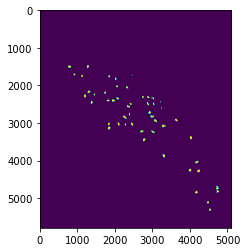

In [49]:
plt.imshow(segmentations_per_area_roi_id['000'][6])

In [52]:
debugged_zstack = segmentations_per_area_roi_id['000'].copy()

Final comparison to previous version:

In [51]:
path = Path('/mnt/c/Users/dsege/TEMP/findmycells_projects/debugging_2/TH_in_SN_new_scanner/04_quantified_segmentations/000/')
buggy_zstack = load_zstack_as_array_from_single_planes(path, '0004')

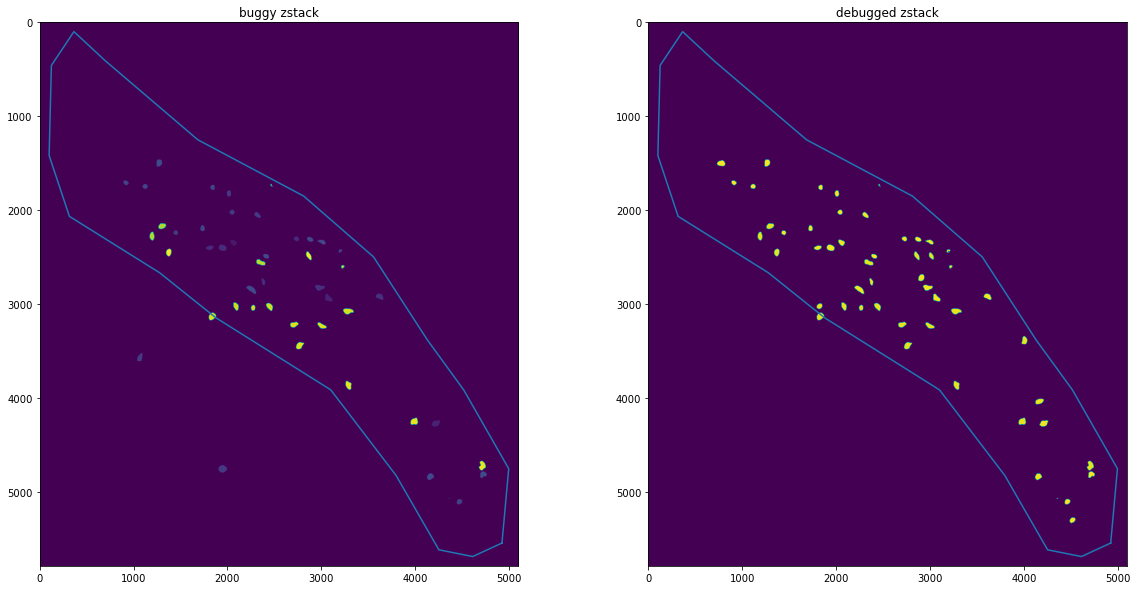

In [55]:
fig = plt.figure(figsize=(20,10), facecolor='white')
gs = fig.add_gridspec(1,2)

fig.add_subplot(gs[0, 0])
                      
plt.plot(x, y)
plt.imshow(buggy_zstack[6])
plt.title('buggy zstack')


fig.add_subplot(gs[0, 1])
                      
plt.plot(x, y)
plt.imshow(debugged_zstack[6])
plt.title('debugged zstack')
plt.show()

In [19]:
final_ids

{2000: {'plane_index': [0, 1, 2, 3, 4, 5, 6, 7],
  'original_label_id': [1, 1, 1, 1, 2, 2, 1, 1]},
 2001: {'plane_index': [0, 1, 2], 'original_label_id': [2, 2, 2]},
 2002: {'plane_index': [0, 1, 2], 'original_label_id': [3, 3, 3]},
 2003: {'plane_index': [0, 1, 2, 3, 4], 'original_label_id': [4, 4, 4, 2, 3]},
 2004: {'plane_index': [0, 1, 2, 3], 'original_label_id': [5, 5, 5, 3]},
 2005: {'plane_index': [0, 1, 2, 3, 4], 'original_label_id': [6, 6, 6, 4, 4]},
 2006: {'plane_index': [0, 1, 2, 3], 'original_label_id': [7, 7, 7, 6]},
 2007: {'plane_index': [0, 1, 2, 3, 4, 5],
  'original_label_id': [8, 8, 8, 5, 5, 3]},
 2008: {'plane_index': [0, 1, 2, 3, 4], 'original_label_id': [9, 9, 9, 8, 7]},
 2009: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [10, 10, 10, 9, 8]},
 2010: {'plane_index': [0, 1, 2], 'original_label_id': [11, 12, 14]},
 2011: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [12, 15, 17, 13, 10]},
 2012: {'plane_index': [0, 1, 2, 3, 4, 5, 6],
  'original

In [17]:
final_label_ids = []
for plane_id in roi_matching_results.keys():
    for label_id in roi_matching_results[plane_id].keys():
        final_label_ids.append(roi_matching_results[plane_id][label_id]['final_label_id'])

In [18]:
len(set(final_label_ids))

130

In [16]:
roi_matching_results

{0: {1: {'final_label_id_assigned': True,
   'final_label_id': 2000,
   'area': 1329.0,
   'matching_ids_previous_plane': [],
   'full_overlap_previous_plane': [],
   'overlapping_area_previous_plane': [],
   'IoUs_previous_plane': [],
   'matching_ids_next_plane': [1],
   'full_overlap_next_plane': [True],
   'overlapping_area_next_plane': [1.0],
   'IoUs_next_plane': [0.773348850741926],
   'best_match_previous_plane': None,
   'overlapping_area_best_match_previous_plane': None,
   'IoU_best_match_previous_plane': None,
   'best_match_next_plane': 1,
   'overlapping_area_best_match_next_plane': 1.0,
   'IoU_best_match_next_plane': 0.773348850741926},
  2: {'final_label_id_assigned': True,
   'final_label_id': 2001,
   'area': 3249.0,
   'matching_ids_previous_plane': [],
   'full_overlap_previous_plane': [],
   'overlapping_area_previous_plane': [],
   'IoUs_previous_plane': [],
   'matching_ids_next_plane': [2],
   'full_overlap_next_plane': [False],
   'overlapping_area_next_plane'

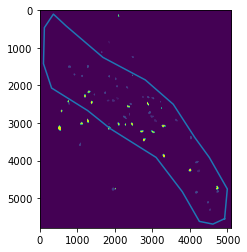

In [15]:
plt.plot(x, y)
plt.imshow(reconstructed_zstack[6])